# Face recognition - KNN Classifier


*   Tài liệu tham khảo: [face_recognitiont/ageitgey](https://github.com/ageitgey/face_recognition)
*   Học viên: Lý Quang Vũ - CH1801040



# I. Mô tả bài toán

![alt text](https://)



* (1) Chọn và sử dụng một hình ảnh bất kỳ (chứa một hoặc nhiều người với nhiều khuôn mặt khác nhau) làm ảnh đầu vào 

* (2) Sử dụng API được cung cấp sẵn từ module face_recognition để xác định vị trí của từng khuôn mặt trong ảnh đầu vào 

* (3) Sử dụng model KNN để dự đoán thông tin từng khuôn mặt (cụ thể là tên của từng người), sau đó thông tin dự đoán được sẽ được gán cho từng khuôn mặt tương ứng. 

> Model KNN này được tạo ra bằng quá trình training tập hình ảnh cho trước. Các hình ảnh cho trước này sẽ được tổ chức theo cấu trúc thư mục nhất định (*tham khảo phần 2 - Các bước thực hiệ*n)

*   (4) Kết quả của bài toán là xuất ra hình ảnh ban đầu, định vị khuôn mặt và dán nhãn (tên) cho từng khuôn mặt có trên hình ảnh ban đầu.

#II. Các bước thực hiện

*   Download module face_recognition:  
[https://github.com/ageitgey/face_recognition](https://github.com/ageitgey/face_recognition)

*   Download tập hình ảnh dùng để train và tạo model
[FaceDB_Google_Drive](https://drive.google.com/drive/u/1/folders/1XupfOJQg7foEyONMgBCEIY6Z0-0E9gYz)

*   Tổ chức thư mục theo cấu trúc như bên dưới:

# III. Code

Phần code sẽ có 3 phần chính:

1.   Training data để tạo ra model


*   Load từng hình ảnh trong từng thư mục -> định vị khuôn mặt -> encoding -> lưu giá trị vào mảng cùng với tên tương ứng

*   Training -> tạo ra model -> save model để dùng cho các lần sau


2.   Sử dụng model vừa tạo ra để dự đoán ảnh đầu vào và đưa ra thông tin


*   Load hình ảnh đầu vào -> định vị khuôn mặt -> encoding -> lưu giá trị

*   Sử dụng model vừa tạo -> so sánh giá trị distance gần nhất -> đưa ra dự đoán


3.   Thể hiện thông tin nhận được trên hình ảnh ban đâu và xuất ra kết quả 


*   Load từng hình ảnh ban đầu -> load dữ liệu về tọa độ khuôn mặt, tên -> thể hiện lên hình ảnh và xuất hình ảnh










In [1]:
# Kết nối đến Google Drive (yêu cầu password)
from google.colab import drive
drive.mount('/content/drive')

# Move to directory 
%cd drive/'My Drive'/'SDH-UIT-CH18'/'Chuyen de thi giac may tinh'/'face_recognition_knn'

KeyboardInterrupt: ignored

In [0]:
!pwd

/content/drive/My Drive/SDH-UIT-CH18/Chuyen de thi giac may tinh/face_recognition_knn


In [7]:
pip install git+https://github.com/ageitgey/face_recognition_models

  Cloning https://github.com/ageitgey/face_recognition_models to /tmp/pip-req-build-83jktgoj
  Running command git clone -q https://github.com/ageitgey/face_recognition_models /tmp/pip-req-build-83jktgoj
ERROR: Operation cancelled by user


KeyboardInterrupt: ignored

In [8]:
!pip install face_recogntion

  ERROR: Could not find a version that satisfies the requirement face_recogntion (from versions: none)
ERROR: No matching distribution found for face_recogntion


In [6]:
# Import các thư viện hỗ trợ

import cv2, numpy, math
from sklearn import neighbors
import os
import os.path
import matplotlib.pyplot as plt
import pickle
import face_recognition
from face_recognition.face_recognition_cli import image_files_in_folder


ModuleNotFoundError: ignored

In [0]:
# Định nghĩa kiểu hình ảnh đầu vào
ALLOWED_EXTENSIONS = {'png', 'jpg'}

# Viết hàm training tập dữ liệu hình ảnh => tạo và save một mode predict
def train(train_dir, model_save_path=None, n_neighbors=None, knn_algo='ball_tree', verbose=False):
    
    # Mảng X và y lần lượt chứa giá trị vùng ảnh khuôn mặt và nhãn (tên) tương ứng
    X = []
    y = []

    # Tạo vòng lặp duyệt hết tất cả các sub-folder trong folder train
    for class_dir in os.listdir(train_dir):
        if not os.path.isdir(os.path.join(train_dir, class_dir)):
            continue

        # Tạo vòng lặp duyệt các hình ảnh trong từng thư folder của mỗi người
        for img_path in image_files_in_folder(os.path.join(train_dir, class_dir)):
          
            # Gọi API đọc ảnh đầu vào
            image = face_recognition.load_image_file(img_path) 
            
            # Gọi API xác định tọa độ khuôn mặt
            # Các thuộc tính:
            #  number_of_times_to_upsample = [number]: số càng lớn dùng cho khuôn mặt càng nhỏ
            #  model [cnn hoặc hog]
            face_bounding_boxes = face_recognition.face_locations(image, number_of_times_to_upsample=1,model='hog')
            
            # Nếu không tìm thấy khuôn mặt (len() bằng 0) hoặc tìm thấy nhiều khuôn mặt cùng lúc (len() > 1). 
            # => bỏ qua hình ảnh. Do đầy là tập train, mỗi ảnh chỉ được phép chứa một khuôn mặt
            if len(face_bounding_boxes) != 1:          
                if verbose:
                    print("Image {} not suitable for training: {}".format(img_path, "Didn't find a face" if len(face_bounding_boxes) < 1 else "Found more than one face"))
            else:
                # Đưa giá trị encoding vùng chứa ảnh khuôn mặt vào mảng X[], tương ứng với tên của khuôn mặt vào mảng y[]
                # (image,known_face_locations=face_bounding_boxes)[0] do chỉ có một khuôn mặt nên chỉ lấy phần tử đầu tiên trong mảng
                X.append(face_recognition.face_encodings(image, known_face_locations=face_bounding_boxes)[0])
                y.append(class_dir)

    # Determine how many neighbors to use for weighting in the KNN classifier, mặc định sẽ bằng 8
    if n_neighbors is None:
        n_neighbors = int(round(math.sqrt(len(X))))
        if verbose:
            print("Chose n_neighbors automatically:", n_neighbors)

    # Khởi tạo và train model
    # Các tham số
    #  algorithm:
    #  weights:
    knn_clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=knn_algo, weights='distance')
    knn_clf.fit(X, y)

    # Save model đã train
    if model_save_path is not None:
        with open(model_save_path, 'wb') as f:
            pickle.dump(knn_clf, f)

    # Kết quả hàm train() sẽ trả về một model KNN classifier
    return knn_clf

In [0]:
def predict(X_img_path, model_path, distance_threshold=0.6):
    
    if not os.path.isfile(X_img_path) or os.path.splitext(X_img_path)[1][1:] not in ALLOWED_EXTENSIONS:
        raise Exception("Sai đường dẫn hình ảnh: {}".format(X_img_path))

    # Load model đã train trước đó và gán vào một biến
    knn_clf = pickle.load(open(model_path, 'rb'))

    # Load ảnh đầu vào và xác định tọa độ khuôn mặt trong ảnh sử dụng model='hog' nhằm tăng tốc độ xử lý
    X_img = face_recognition.load_image_file(X_img_path)
    X_face_locations = face_recognition.face_locations(X_img,number_of_times_to_upsample=1,model='hog')

    # Trường hợp không tìm được khuôn mặt, trả về giá trị rỗng.
    if len(X_face_locations) == 0:
        return []

    # Encoding vùng ảnh chứa khuôn mặt của ảnh đầu vào
    faces_encodings = face_recognition.face_encodings(X_img, known_face_locations=X_face_locations)

    # Sử dụng KNN model đã load ở trên, so sánh và tìm ra kết quả so sánh tốt nhất (gần nhất) so với ảnh đầu vào
    # Use the KNN model to find the best matches for the test face
    closest_distances = knn_clf.kneighbors(faces_encodings, n_neighbors=1)
    are_matches = [closest_distances[0][i][0] <= distance_threshold for i in range(len(X_face_locations))]

    # Kết quả sẽ trả về tọa độ khuôn mặt và tên tương ứng. Trường hợp không xác định sẽ được gán là 'unknown'
    return [(pred, loc) if rec else ("unknown", loc) for pred, loc, rec in zip(knn_clf.predict(faces_encodings), X_face_locations, are_matches)]

In [0]:
# Hàm hiển thị kết quả, thể hiện vùng khuôn mặt tìm được và tên tương ứng với từng khuôn mặt
def show_prediction_labels_on_image(img_path, predictions):
    
    # Load hình ảnh 
    img = cv2.imread(img_path)
         

    # Mỗi hình ảnh sẽ có giá trị về tọa độ khuôn mặt và tên tương ứng
    for name, (top, right, bottom, left) in predictions:
        
        # Vẽ khung box với 
        # cv2.rectangle(hình dảnh vào, tọa độ(left, top), tọa độ(right, bottom), màu sắc, độ dày nét) 
        cv2.rectangle(img, (left, top), (right, bottom), (0, 255, 0),2)
        
        # Thể hiện text trên ảnh với 
        #  cv2.putText(hình ảnh vào, tên, Tọa độ (left,top), font chữ, độ lớn chữ, màu sắc, độ dầy nét chữ)
        cv2.putText(img, name, (left, top), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 2)
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

    plt.show()

In [0]:
# Hiển thị thông báo training thành công
if __name__ == "__main__":
    
    print("Training KNN classifier...")
    classifier = train("FaceDB", model_save_path="trained_knn_model_2.clf", n_neighbors=2)
    print("Training complete!")

    

Training KNN classifier...
Training complete!


Những khuôn mặt trong img_test1.png
- Tìm thấy VULQ tại tọa độ (left, top, right, bottom)(50, 199, 93, 242)
- Tìm thấy HOBV tại tọa độ (left, top, right, bottom)(296, 257, 348, 308)
- Tìm thấy MINHHA tại tọa độ (left, top, right, bottom)(349, 322, 411, 384)
- Tìm thấy MINHHA tại tọa độ (left, top, right, bottom)(213, 218, 256, 262)
- Tìm thấy VULQ tại tọa độ (left, top, right, bottom)(541, 234, 577, 270)
- Tìm thấy TULG tại tọa độ (left, top, right, bottom)(371, 190, 415, 233)
- Tìm thấy HOAISD tại tọa độ (left, top, right, bottom)(550, 288, 612, 350)


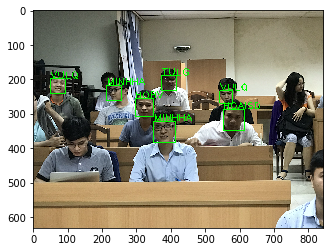

Những khuôn mặt trong img_test2.png
- Tìm thấy HOAISD tại tọa độ (left, top, right, bottom)(481, 230, 517, 266)
- Tìm thấy TAIHPT tại tọa độ (left, top, right, bottom)(667, 336, 729, 398)
- Tìm thấy HANTQ tại tọa độ (left, top, right, bottom)(38, 343, 100, 405)
- Tìm thấy MINHHA tại tọa độ (left, top, right, bottom)(376, 252, 419, 295)
- Tìm thấy QUANVM tại tọa độ (left, top, right, bottom)(137, 210, 173, 246)
- Tìm thấy HOBV tại tọa độ (left, top, right, bottom)(341, 214, 377, 250)
- Tìm thấy VULQ tại tọa độ (left, top, right, bottom)(193, 206, 229, 242)
- Tìm thấy MINHHA tại tọa độ (left, top, right, bottom)(301, 186, 337, 222)
- Tìm thấy unknown tại tọa độ (left, top, right, bottom)(773, 214, 809, 250)


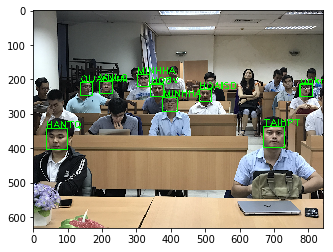

Những khuôn mặt trong img_test3.png
- Tìm thấy MINHHA tại tọa độ (left, top, right, bottom)(589, 206, 625, 242)
- Tìm thấy NHANTH tại tọa độ (left, top, right, bottom)(31, 239, 83, 291)


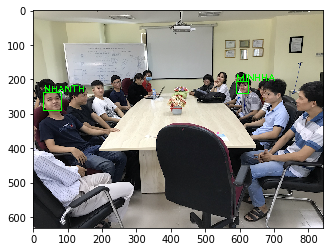

Những khuôn mặt trong img_test4.png
- Tìm thấy MINHHA tại tọa độ (left, top, right, bottom)(477, 310, 513, 346)
- Tìm thấy TULG tại tọa độ (left, top, right, bottom)(345, 286, 381, 322)
- Tìm thấy QUANVM tại tọa độ (left, top, right, bottom)(33, 278, 69, 314)


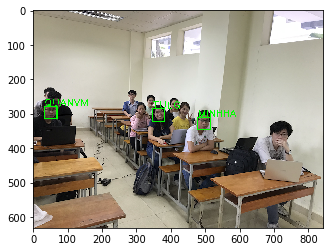

In [0]:
    for image_file in os.listdir("Test"):
        full_file_path = os.path.join("Test", image_file)

        print("Những khuôn mặt trong {}".format(image_file))

        # Tìm tất cả khuôn mặt trong ảnh sử dũng model đã train trước đó
        predictions = predict(full_file_path, model_path="trained_knn_model_2.clf")

        # In kết quả
        for name, (top, right, bottom, left) in predictions:
            print("- Tìm thấy {} tại tọa độ (left, top, right, bottom)({}, {}, {}, {})".format(name, left, top, right, bottom))

        # Display results overlaid on an image
        show_prediction_labels_on_image(os.path.join("Test", image_file), predictions)

# IV. Đánh giá

**1.   Dataset**


*   Số lương thư mục tương ứng mỗi người: 23 thư mục
*   Tổng số ảnh: 65 ảnh (trung bình một thư mục có hơn 2 ảnh ) 

**2.   Test**


*   Số lương ảnh test: 4 ảnh
*  Tổng số khuôn mặt: ~50 khuôn mặt (trung bình một ảnh có 12-13 khuôn mặt/ảnh)
*   Tổng số khuôn mặt được detect: 21



  Cụ thể:

> ***Test 1***

   
>> Tổng số khuôn mặt: 10

>>  Detect và predict: 7/10

>>  ***Nhận xét: Ảnh được chụp với góc trực diẹn, khuôn mặt rõ, tỉ lệ detect cao***


> ***Test 2***

>> Tổng số khuôn mặt: 19

>> Detect và predict: 9/19

>> ***Nhận xét: Ảnh được chụp với góc trực diện, tuy nhiên, khuôn mặt nhỏ do chụp xa, tỉ lệ detect không cao như ảnh đầu tiên ***


> ***Test 3***

>> Tổng số khuôn mặt: 12

>> Detect và predict: 2/12

>>  ***Nhận xét: Ảnh chụp ngang mặt, hầu như không thể detect được ***

> ***Test 4***

>> Tổng số khuôn mặt: 9
>> Detect và predict: 3/9
>>  ***Nhận xét: Tương tự ảnh test 3, lần này ảnh chụp nghiên 45 độ, tỉ lệ detect được khuôn mặt không cao ***







# V. Kết luận

> Kết quả từ những trường hợp test bên trên cho thấy, tỉ lệ thành công trong bài toán nhận diện khuôn mặt phụ thuộc rất nhiều điều, cụ thể như:


> -- Chịu ảnh hưởng từ hình ảnh đầu vào (input): hình ảnh đầu vào với nhiều góc độ, độ sáng khác nhau gây ảnh hưởng ít nhiều trong quá trình detect.

> -- Dataset và Thuật toán: dataset trong việc training cần cần lượng lớn hình ảnh khác nhau (góc độ khuôn mặt, độ sáng hình ảnh,...), kết hợp với các thuật toán khác nhau để tăng khả năng nhận diện chính xác khuôn mặt người


